In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from skimage.metrics import contingency_table
from streamlit import connection

# Phase 1-1
## 1-1A

Data is saved in 4 csv files: connections, devices, processes, profiles. One row = one entry. Separator is tab. Key connecting all tables is imei, which means a unique device identifier. Some values (like iso for Namibia) are by default interpreted as NaN, therefore we have to specify the na_values parameter.

In [5]:
connections, devices, processes, profiles = pd.read_csv('data/connections.csv', sep='\t', keep_default_na=False), pd.read_csv('data/devices.csv', sep='\t', keep_default_na=False), pd.read_csv('data/processes.csv', sep='\t', keep_default_na=False), pd.read_csv('data/profiles.csv', sep='\t', keep_default_na=False)

We define functions that will prove useful in data inspection later.

In [6]:
# we also define a function to count outliers, since there isn't a built-in method for that
def count_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    return column[(column < q1 - 1.5*iqr) | (column > q3 + 1.5*iqr)].shape[0]

### Connections
Initially we print the first few rows of the connections table to get a sense of the data.

In [7]:
connections.head()

,ts,imei,mwra,c.android.youtube,c.dogalize,c.android.gm,c.katana,c.android.chrome,c.raider,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.updateassist
0,2018-05-05 10:00:00,3590433799317661107,0.0,11.65403,10.65335,10.48791,16.91620,5.04564,36.21508,14.24956,4.09319,15.20934,5.11764
1,2018-05-05 10:01:00,3590433799317662063,1.0,10.29551,10.46363,10.98438,15.65637,14.82931,24.83765,57.49911,23.94919,8.82448,44.13570
2,2018-05-05 10:02:00,863033069630348313,0.0,12.12831,9.53752,6.78080,6.98948,10.92433,3.29441,20.37891,52.55353,49.51037,99.75215
3,2018-05-05 10:03:00,359043379931766114,1.0,11.06419,11.55759,8.87744,11.84499,15.45902,24.78878,36.40299,25.77644,21.84167,65.17774
4,2018-05-05 10:04:00,3590433799317661842,1.0,12.08457,10.42860,9.82241,12.48869,12.85363,40.98237,74.13316,96.77450,18.48116,90.77304


We analyze the structure of the table.

In [8]:
print(f"There are {connections.shape[0]} entries with {connections.shape[1]} columns:\n {connections.columns.values}")

There are 15074 entries with 13 columns:
 ['ts' 'imei' 'mwra' 'c.android.youtube' 'c.dogalize' 'c.android.gm'
 'c.katana' 'c.android.chrome' 'c.raider' 'c.android.vending'
 'c.UCMobile.intl' 'c.UCMobile.x86' 'c.updateassist']


In [9]:
connections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15074 entries, 0 to 15073
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ts                 15074 non-null  object 
 1   imei               15074 non-null  int64  
 2   mwra               15074 non-null  float64
 3   c.android.youtube  15074 non-null  float64
 4   c.dogalize         15074 non-null  float64
 5   c.android.gm       15074 non-null  float64
 6   c.katana           15074 non-null  float64
 7   c.android.chrome   15074 non-null  float64
 8   c.raider           15074 non-null  float64
 9   c.android.vending  15074 non-null  float64
 10  c.UCMobile.intl    15074 non-null  float64
 11  c.UCMobile.x86     15074 non-null  float64
 12  c.updateassist     15074 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.5+ MB


This dataset contains no missing values, as the number of non-null entries in each column matches the total row count. The first column holds object type values, representing timestamps, and will likely be converted to timestamp type during further processing. The second column stores int64 values, which represent the International Mobile Equipment Identity (IMEI) number. The third column is of type float64 despite containing only boolean values, which indicate malware-related activity. The other columns are of type float64  serving as input for evaluating mwra. 

The pair of first and second column (ts, imei) are keys for snapshot of the rest of values. The third column is the result of evaluation. 

In [10]:
connections.describe()

,imei,mwra,c.android.youtube,c.dogalize,c.android.gm,c.katana,c.android.chrome,c.raider,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.updateassist
count,1.507400e+04,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000
mean,3.944186e+18,0.628367,10.649835,11.159652,9.960639,11.779597,9.983044,49.518952,50.033587,50.042579,49.858606,49.845721
std,3.331167e+18,0.483257,2.541594,2.787612,2.564320,2.332968,2.609872,28.933385,28.855641,28.955827,29.024959,28.848587
min,3.590434e+17,0.000000,1.023410,0.113470,0.022370,2.299720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.630331e+17,0.000000,8.759405,9.342795,8.119385,10.424308,8.128787,24.551032,24.985702,24.950173,24.570863,24.762352
50%,3.590434e+18,1.000000,10.527030,11.410130,9.868480,12.011270,9.935055,49.285175,50.404290,50.368725,49.839325,49.573495
75%,8.630331e+18,1.000000,12.507920,13.140740,11.798052,13.362262,11.872960,74.746440,75.024978,74.937760,75.378667,74.872277
max,8.630331e+18,1.000000,20.726030,19.477060,18.284120,19.684410,19.927250,100.000000,100.000000,100.000000,100.000000,100.000000


From the method above, we can get a sense of distributions for each column. Especially mean close to the median suggest normal distribution.

### Devices

In [11]:
devices.head()

,latitude,longitude,store_name,code,location,imei
0,18.57677,-72.22625,Croix-des-Bouquets,HT,America/Port-au-Prince,3590433799317662113
1,-25.54073,152.70493,Maryborough,AU,Australia/Brisbane,8630330696303481107
2,50.88506,4.07601,Denderleeuw,BE,Europe/Brussels,8630330696303481461
3,48.15659,28.28489,Soroca,MD,Europe/Chisinau,3590433799317661016
4,-34.64966,-58.38341,Barracas,AR,America/Argentina/Buenos_Aires,3590433799317662253


In [12]:
print(f"There are {devices.shape[0]} entries with {devices.shape[1]} columns:\n {devices.columns.values}")


There are 2895 entries with 6 columns:
 ['latitude' 'longitude' 'store_name' 'code' 'location' 'imei']


In [13]:
devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2895 entries, 0 to 2894
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    2895 non-null   float64
 1   longitude   2895 non-null   float64
 2   store_name  2895 non-null   object 
 3   code        2895 non-null   object 
 4   location    2895 non-null   object 
 5   imei        2895 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 135.8+ KB


Column 'code' has 3 null values. Others don't have any. 

In [14]:
devices.describe()

,latitude,longitude,imei
count,2895.000000,2895.000000,2.895000e+03
mean,29.379861,9.846564,3.919073e+18
std,23.348693,73.262963,3.333461e+18
min,-54.800000,-156.474320,3.590434e+17
25%,14.933330,-60.931730,8.630331e+17
50%,36.766390,9.152140,3.590434e+18
75%,46.655810,71.211690,8.630331e+18
max,68.798330,178.004170,8.630331e+18


Latitude and longitude often act more as a categorical data instead of numerical, when it comes to analysis, as they split into categories rather than attributes growing in a linear fashion. IMEI is an id. Therefore the cell above provides no useful insight.

In [15]:
processes.head()

,ts,imei,mwra,p.android.chrome,p.android.documentsui,p.android.gm,p.system,p.android.packageinstaller,p.android.settings,p.android.externalstorage,...,p.dogalize,p.simulator,p.google,p.android.vending,p.inputmethod.latin,p.process.gapps,p.notifier,p.olauncher,p.gms.persistent,p.android.defcontainer
0,2018-05-05 10:00:00,3590433799317661107,0.0,7.41473,10.17656,14.80917,12.14702,11.55620,8.33912,14.02450,...,65.61120,50.11483,53.37584,68.21001,61.69014,42.31022,4.82212,90.97861,53.94759,20.98954
1,2018-05-05 10:01:00,3590433799317662063,1.0,9.40603,6.57378,6.06519,10.56643,16.74062,13.78434,7.57297,...,47.85939,64.64494,15.73793,58.42507,57.04862,40.09440,16.63539,30.11126,40.51207,64.61017
2,2018-05-05 10:02:00,863033069630348313,0.0,13.61225,11.73312,8.99679,10.79425,12.60312,10.78121,11.90788,...,52.33884,25.01553,42.88480,17.22521,13.74976,50.38813,42.62046,96.70838,43.37143,98.71501
3,2018-05-05 10:03:00,359043379931766114,1.0,8.14970,9.53996,8.28249,10.80629,13.97670,12.73047,11.64714,...,28.18437,55.22909,59.59616,78.03742,20.18875,20.99686,90.73121,86.05335,99.16606,95.92975
4,2018-05-05 10:04:00,3590433799317661842,1.0,8.20358,8.94156,8.62248,8.33003,13.44049,13.31239,11.40689,...,71.31165,60.24955,52.48479,13.37139,51.12877,70.85514,39.65245,29.01586,6.11403,65.87936


In [16]:
print(f"There are {processes.shape[0]} entries with {processes.shape[1]} columns:\n {processes.columns.values}")

There are 15074 entries with 23 columns:
 ['ts' 'imei' 'mwra' 'p.android.chrome' 'p.android.documentsui'
 'p.android.gm' 'p.system' 'p.android.packageinstaller'
 'p.android.settings' 'p.android.externalstorage' 'p.android.gms'
 'p.katana' 'p.browser.provider' 'p.dogalize' 'p.simulator' 'p.google'
 'p.android.vending' 'p.inputmethod.latin' 'p.process.gapps' 'p.notifier'
 'p.olauncher' 'p.gms.persistent' 'p.android.defcontainer']


In [17]:
processes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15074 entries, 0 to 15073
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ts                          15074 non-null  object 
 1   imei                        15074 non-null  int64  
 2   mwra                        15074 non-null  float64
 3   p.android.chrome            15074 non-null  float64
 4   p.android.documentsui       15074 non-null  float64
 5   p.android.gm                15074 non-null  float64
 6   p.system                    15074 non-null  float64
 7   p.android.packageinstaller  15074 non-null  float64
 8   p.android.settings          15074 non-null  float64
 9   p.android.externalstorage   15074 non-null  float64
 10  p.android.gms               15074 non-null  float64
 11  p.katana                    15074 non-null  float64
 12  p.browser.provider          15074 non-null  float64
 13  p.dogalize                  150

Same as the connections table, there are no null values in any columns. Other details are also the same as in the connections table.

In [18]:
processes.describe()

,imei,mwra,p.android.chrome,p.android.documentsui,p.android.gm,p.system,p.android.packageinstaller,p.android.settings,p.android.externalstorage,p.android.gms,...,p.dogalize,p.simulator,p.google,p.android.vending,p.inputmethod.latin,p.process.gapps,p.notifier,p.olauncher,p.gms.persistent,p.android.defcontainer
count,1.507400e+04,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,...,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000
mean,3.944186e+18,0.628367,10.624031,10.088090,9.428202,10.055861,12.395920,11.247557,11.242832,47.251979,...,50.848156,45.156014,49.467709,49.666323,49.639707,50.260145,50.290151,49.752762,49.817193,49.571407
std,3.331167e+18,0.483257,2.580956,2.380393,2.392442,2.646287,1.841499,2.572235,2.766107,12.825330,...,13.234067,11.425622,13.496016,28.950774,28.891075,28.812835,28.812182,28.678112,28.951400,29.061716
min,3.590434e+17,0.000000,1.596390,3.929200,1.529690,0.051170,5.165220,1.636750,1.918450,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.630331e+17,0.000000,8.704740,8.362568,7.834278,8.189795,11.167677,9.465430,9.340640,38.517235,...,41.845320,37.395083,40.257945,24.730168,24.392198,25.262542,25.568478,25.376043,24.504192,24.162805
50%,3.590434e+18,1.000000,10.369065,9.740430,9.165670,9.794255,12.409595,11.408155,11.333865,47.241170,...,50.959360,45.116790,49.738240,49.261350,49.561340,50.040285,50.540960,49.815600,49.470135,50.005440
75%,8.630331e+18,1.000000,12.449768,11.652207,10.747598,11.811273,13.617365,13.093542,13.186208,55.997227,...,59.832208,52.859875,58.620773,74.841612,74.672930,75.275445,75.288210,74.053022,74.966813,74.796243
max,8.630331e+18,1.000000,19.996520,18.814960,20.640630,21.245590,20.075470,19.985360,21.755430,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


We can again see that the mean is mostly close to the median, which suggests normal distribution. 

In [19]:
profiles.head()

,name,mail,registration,job,ssn,company,current_location,username,imei,residence,user_id,address
0,Matthew Powell,floreseugene@yahoo.com,14 Mar 2024,,219-60-6090,Hicks-Drake,"(Decimal('-27.447495'), Decimal('-43.231283'))",kcalderon,3590433799317661974,,2401,"84859 Nunez Lock Suite 082\nWest Rossside, HI ..."
1,Nicole Richards,fthompson@gmail.com,2023-01-13,,049-88-9351,"Nguyen, White and Lopez","(Decimal('39.235450'), Decimal('138.429324'))",pgarcia,8630330696303481198,"662 Christopher Point\nWest Matthew, VT 84352",1147,"9123 Traci Pines\nLindastad, ME 99569"
2,Andrew Smith,megan89@yahoo.com,17 Apr 2019,,039-54-7186,Navarro-Goodman,"(Decimal('-22.094944'), Decimal('-141.211383'))",sramos,8630330696303482071,"9912 Jasmine Extension Suite 310\nDianeville, ...",459,"523 Suarez Port Apt. 013\nKellybury, MS 63150"
3,Shane Williams,osimmons@hotmail.com,2023-09-09,"Administrator, Civil Service",453-34-1867,"Brown, Compton and Thompson","(Decimal('39.9652785'), Decimal('-39.378417'))",ioneill,863033069630348826,,1587,"4827 Morgan Mission\nWest Michaelborough, AL 1..."
4,Patricia Leach,prodriguez@yahoo.com,"01/30/2018, 00:00:00",,785-50-4993,Pratt PLC,,michaelhart,359043379931766403,,2312,"48666 William View\nEricbury, OH 12135"


In [20]:
print(f"There are {profiles.shape[0]} entries with {profiles.shape[1]} columns:\n {profiles.columns.values}")

There are 2605 entries with 12 columns:
 ['name' 'mail' 'registration' 'job' 'ssn' 'company' 'current_location'
 'username' 'imei' 'residence' 'user_id' 'address']


In [21]:
profiles.describe()

,imei,user_id
count,2.605000e+03,2605.000000
mean,3.884606e+18,1334.530902
std,3.311186e+18,747.780003
min,3.590434e+17,0.000000
25%,8.630331e+17,679.000000
50%,3.590434e+18,1346.000000
75%,8.630331e+18,1995.000000
max,8.630331e+18,2604.000000


There are again only categorical data, so this cell doesn't provide any useful insight.

In [22]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              2605 non-null   object
 1   mail              2605 non-null   object
 2   registration      2605 non-null   object
 3   job               2605 non-null   object
 4   ssn               2605 non-null   object
 5   company           2605 non-null   object
 6   current_location  2605 non-null   object
 7   username          2605 non-null   object
 8   imei              2605 non-null   int64 
 9   residence         2605 non-null   object
 10  user_id           2605 non-null   int64 
 11  address           2605 non-null   object
dtypes: int64(2), object(10)
memory usage: 244.3+ KB


We can see all the columns are categorical. Further we can see that columns job and residence have a lot of missing values.

## 1-1B
For better results, analysis should be repeated for cleaned data.


* Connections
    - c.android.youtube
    - c.dogalize
* Devices
    - store_name
    - code
    - location
* Processes
    - p.system
    - p.android.gm
* Profiles
    - company
* Common
    - Between connections and processes: ts
    - Between all tables: imei

### column: imei

In [23]:
for table in [connections, devices, processes, profiles]:
    print(table['imei'].describe(),'\nUnique values:', table['imei'].nunique(), '\n')

count    1.507400e+04
mean     3.944186e+18
std      3.331167e+18
min      3.590434e+17
25%      8.630331e+17
50%      3.590434e+18
75%      8.630331e+18
max      8.630331e+18
Name: imei, dtype: float64 
Unique values: 500 

count    2.895000e+03
mean     3.919073e+18
std      3.333461e+18
min      3.590434e+17
25%      8.630331e+17
50%      3.590434e+18
75%      8.630331e+18
max      8.630331e+18
Name: imei, dtype: float64 
Unique values: 499 

count    1.507400e+04
mean     3.944186e+18
std      3.331167e+18
min      3.590434e+17
25%      8.630331e+17
50%      3.590434e+18
75%      8.630331e+18
max      8.630331e+18
Name: imei, dtype: float64 
Unique values: 500 

count    2.605000e+03
mean     3.884606e+18
std      3.311186e+18
min      3.590434e+17
25%      8.630331e+17
50%      3.590434e+18
75%      8.630331e+18
max      8.630331e+18
Name: imei, dtype: float64 
Unique values: 496 



From the previous cell, only useful information is unique values (roughly 500 in each of them), since mean and quantiles don't matter for id. 

In [24]:
# get counts how many each specific imei is in each table
imei_counts = {
    'connections': connections['imei'].value_counts(),
    'devices': devices['imei'].value_counts(),
    'processes': processes['imei'].value_counts(),
    'profiles': profiles['imei'].value_counts()
}

In [25]:
imei_counts['connections'].describe()

count    500.000000
mean      30.148000
std        5.522961
min       12.000000
25%       26.000000
50%       30.000000
75%       34.000000
max       47.000000
Name: count, dtype: float64

In [26]:
imei_counts['devices'].describe()

count    499.000000
mean       5.801603
std        2.245638
min        1.000000
25%        4.000000
50%        6.000000
75%        7.000000
max       12.000000
Name: count, dtype: float64

In [27]:
imei_counts['processes'].describe()

count    500.000000
mean      30.148000
std        5.522961
min       12.000000
25%       26.000000
50%       30.000000
75%       34.000000
max       47.000000
Name: count, dtype: float64

In [28]:
imei_counts['profiles'].describe()

count    496.000000
mean       5.252016
std        2.192502
min        1.000000
25%        4.000000
50%        5.000000
75%        7.000000
max       13.000000
Name: count, dtype: float64

All the tables show to have roughly 500 distinct imei values. Processes and connections have way higher amount of entries per imei (30) than devices and profiles (about 5).

Text(0.5, 0, 'Number of entries per imei')

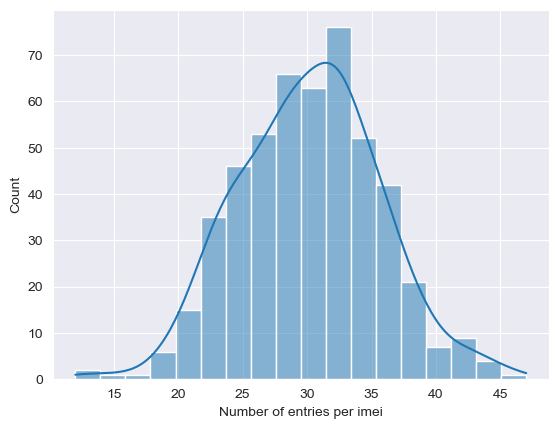

In [29]:
sns.histplot(imei_counts['connections'], kde=True)
plt.xlabel('Number of entries per imei')

Text(0.5, 0, 'Number of entries per imei')

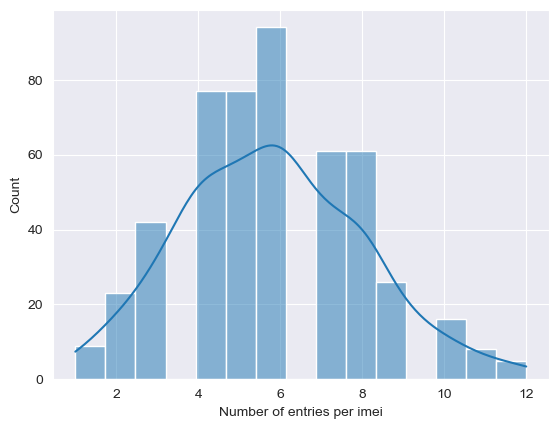

In [30]:
sns.histplot(imei_counts['devices'], kde=True)
plt.xlabel('Number of entries per imei')

Text(0.5, 0, 'Number of entries per imei')

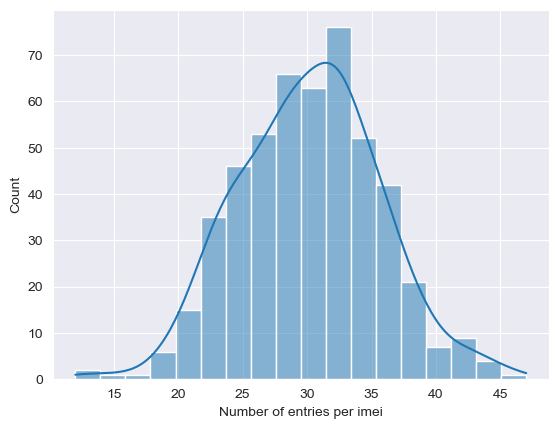

In [31]:
sns.histplot(imei_counts['processes'], kde=True)
plt.xlabel('Number of entries per imei')

Text(0.5, 0, 'Number of entries per imei')

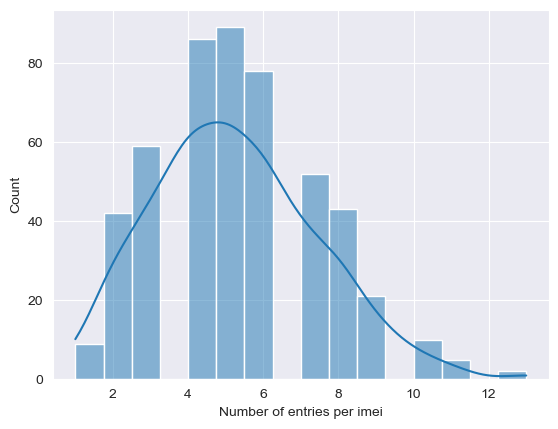

In [32]:
sns.histplot(imei_counts['profiles'], kde=True)
plt.xlabel('Number of entries per imei')

Distribution in tables connections and processes is normal, meaning not all devices have been tested the same amount of times. 
In profiles table, the distribution of imei is resembling normal, although slightly skewed. More entries per imei implies a device is used by multiple users.
In table devices, the distribution is also normal, also skewed. More entries per imei likely implies that device was sold multiple times, or something in that manner.


None of the columns seem to be skewed nor have unusual kurtosis.

In [33]:
for table_name, imei_count in imei_counts.items():
    print(f"{table_name}\n\tSkewness: {stats.skew(imei_count)}\n\tKurtosis: {stats.kurtosis(imei_count)}")

connections
	Skewness: 0.020269235872144426
	Kurtosis: 0.08682182515120385
devices
	Skewness: 0.25375336357679545
	Kurtosis: -0.1925534403016642
processes
	Skewness: 0.020269235872144426
	Kurtosis: 0.08682182515120385
profiles
	Skewness: 0.43709435332792845
	Kurtosis: -0.002120965891310611


In [34]:
for table_name, imei_count in imei_counts.items():
    print(f"{table_name}\n\tnumber of outliers: {count_outliers(imei_count)}")

connections
	number of outliers: 3
devices
	number of outliers: 5
processes
	number of outliers: 3
profiles
	number of outliers: 2


For each of the tables, there are few outliers, appearing either too few times or too many times, but there isn't a significant amount of them.

### column: ts
timestamps appear in both connections and processes tables. 

They are in string format, so first we have to convert them to datetime format.

In [35]:
timestamps = {
    'connections': pd.to_datetime(connections['ts']), 
    'processes': pd.to_datetime(processes['ts'])
}

In [36]:
timestamps['connections'].describe()

count                            15074
mean     2018-05-10 14:03:19.730662144
min                2018-05-05 10:00:00
25%                2018-05-07 23:59:15
50%                2018-05-10 14:04:30
75%                2018-05-13 04:00:45
max                2018-05-15 18:14:00
Name: ts, dtype: object

In [37]:
timestamps['processes'].describe()

count                            15074
mean     2018-05-10 14:03:19.730662144
min                2018-05-05 10:00:00
25%                2018-05-07 23:59:15
50%                2018-05-10 14:04:30
75%                2018-05-13 04:00:45
max                2018-05-15 18:14:00
Name: ts, dtype: object

The describe method shows the same attributes for both tables. Let's check if the timestamps are the same.

In [38]:
timestamps['connections'].equals(timestamps['processes'])

True

Since they are the same, we don't have to check distribution for both tables.

The timestamps are in 1 minute intervals. We can't check if that's true until we remove duplicates (which would add 0min intervals and falsely rule out the assumption).

In [39]:
# have to ignore the first row, because that doesn't have a difference
timestamps['connections_diffs'] = timestamps['connections'].diff()[1:]
print(f"Before removing duplicates:\n\trows with 1minute difference: {sum(timestamps['connections'].diff() == '1min')}\n\tall rows have 1 min difference: {(timestamps['connections_diffs'] == '1min').all()}")
timestamps['connections_unique'] = pd.to_datetime(connections['ts'].drop_duplicates())
timestamps['connections_unique_diffs'] = timestamps['connections_unique'].diff()[1:]
print(f"After removing duplicates:\n\trows with 1minute difference: {sum(timestamps['connections_unique'].diff() == '1min')}\n\tall rows have 1 min difference: {(timestamps['connections_unique_diffs'] == '1min').all()}")
print(f"Since there is {timestamps['connections_unique'].shape[0]} unique timestamps, we can conclude that all the timestamps are in 1 minute intervals meaning uniform distribution.")

Before removing duplicates:
	rows with 1minute difference: 14894
	all rows have 1 min difference: False
After removing duplicates:
	rows with 1minute difference: 14894
	all rows have 1 min difference: True
Since there is 14895 unique timestamps, we can conclude that all the timestamps are in 1 minute intervals meaning uniform distribution.


Visual representation:

<Axes: xlabel='ts', ylabel='Count'>

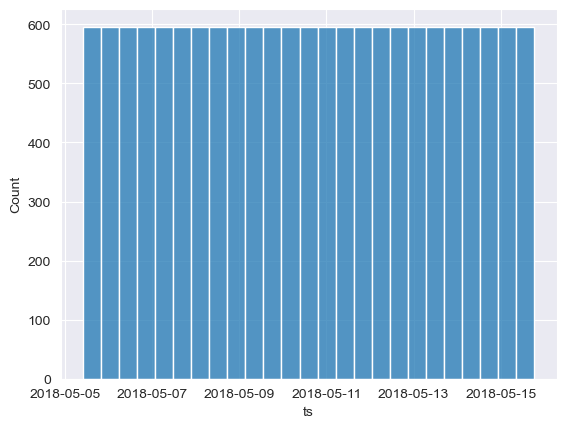

In [40]:
sns.histplot(timestamps['connections_unique'])

There naturally aren't any outliers as the data is uniformly distributed

### Column: connections - c.android.youtube

In [41]:
connections['c.android.youtube'].describe()

count    15074.000000
mean        10.649835
std          2.541594
min          1.023410
25%          8.759405
50%         10.527030
75%         12.507920
max         20.726030
Name: c.android.youtube, dtype: float64

Count is same as the total row count, which means there are no missing values. IQR is about 3.75, so we can clearly see, there are outliers (at least the maximum and minimum values are).

<Axes: xlabel='c.android.youtube', ylabel='Count'>

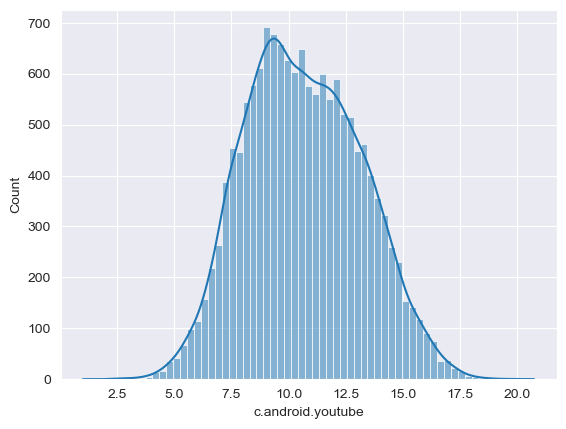

In [42]:
sns.histplot(connections['c.android.youtube'], kde=True)

data appears to be uniformly distributed

The data doesn't seem skewed. It shows slightly negative kurtosis.

In [43]:
print(f"Skewness: {stats.skew(connections['c.android.youtube'])}\nKurtosis: {stats.kurtosis(connections['c.android.youtube'])}")

Skewness: 0.15226536913358077
Kurtosis: -0.43960295056085474


In [44]:
print(f"There are {count_outliers(connections['c.android.youtube'])} outliers in the column.")

There are 17 outliers in the column.


Let's see the outliers in a graph

<Axes: ylabel='c.android.youtube'>

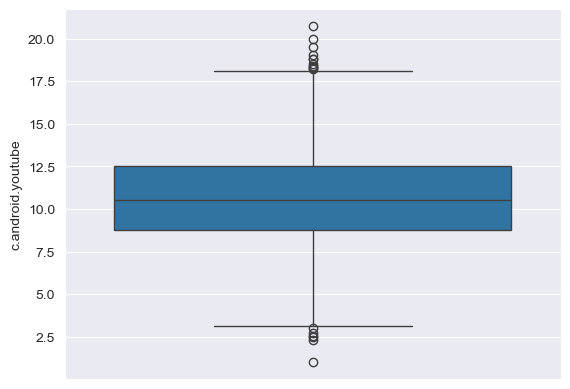

In [45]:
sns.boxplot(connections['c.android.youtube'])

### Column: connections - c.dogalize

In [46]:
connections['c.dogalize'].describe()

count    15074.000000
mean        11.159652
std          2.787612
min          0.113470
25%          9.342795
50%         11.410130
75%         13.140740
max         19.477060
Name: c.dogalize, dtype: float64

Count is the same as the total row count, indicating there are no missing values. The interquartile range (IQR) is about 3.8, which indicates a moderate spread of the middle 50% of the data. The minimum value is quite low (0.11), and the maximum value is 19.48, which suggests that there may be some outliers. The standard deviation is 2.79, showing moderate variability around the mean (11.16), and the median is very close to the mean, indicating normal distribution.

<Axes: xlabel='c.dogalize', ylabel='Count'>

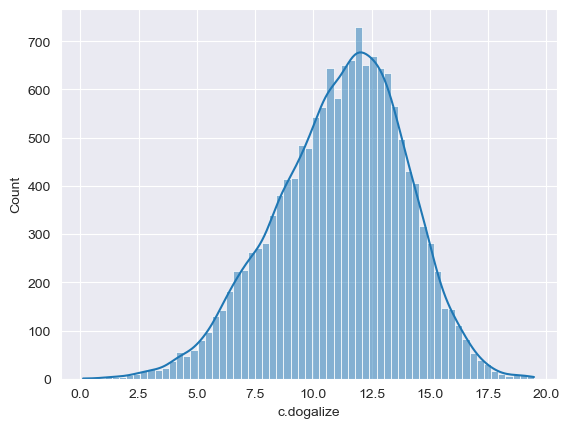

In [47]:
sns.histplot(connections['c.dogalize'], kde=True)

The data is normally distributed, but it seems to be slightly left skewed, so let's check the skewness.

In [48]:
stats.skew(connections['c.dogalize'])

-0.3408326674474093

Also check kurtosis while we at it, but that one seems normal

In [49]:
stats.kurtosis(connections['c.dogalize'])

-0.043511800762510155

Check amount of outliers

In [50]:
count_outliers(connections['c.dogalize'])

115

<Axes: ylabel='c.dogalize'>

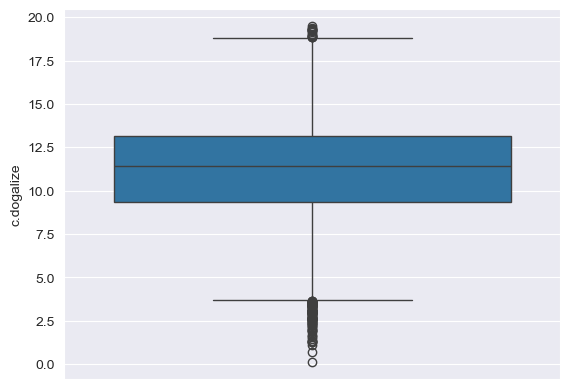

In [51]:
sns.boxplot(connections['c.dogalize'])

Higher number of outliers than before, but still below 1%

### Column: devices - store_name

In [52]:
devices['store_name'].describe()

count        2895
unique        937
top       Mampong
freq            9
Name: store_name, dtype: object

describes shows that only roughly third of the values are unique. Count is same as the total row count, indicating there are no missing values.

Text(0, 0.5, 'Number of stores')

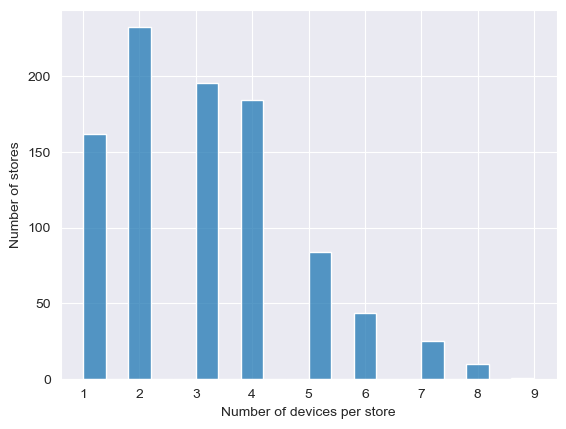

In [53]:
sns.histplot(devices['store_name'].value_counts())
plt.xlabel('Number of devices per store')
plt.ylabel('Number of stores')

Most stores have sold 1-4 devices, other than few exceptions. The distribution is right skewed.

In [54]:
stats.skew(devices['store_name'].value_counts())

0.7251188534572053

There are visibly some outliers. 

In [55]:
count_outliers(devices['store_name'].value_counts())

11

<Axes: ylabel='count'>

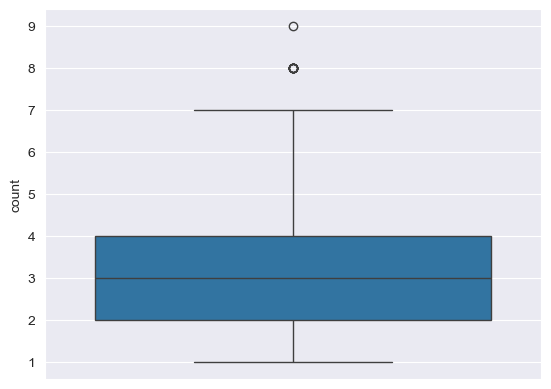

In [56]:
sns.boxplot(devices['store_name'].value_counts())

The biggest one, Mampong, being the only one at 9, while the other outliers are all at 8.

### Column: devices - code 
to be renamed country code

In [57]:
devices['code'].describe()

count     2895
unique     131
top         US
freq       508
Name: code, dtype: object

There are 131 distinct values and no missing values. The most frequent one is US, which appears in almost 20% of the rows.

In [58]:
devices['code'].value_counts().describe()

count    131.000000
mean      22.099237
std       53.511588
min        1.000000
25%        4.000000
50%        6.000000
75%       16.000000
max      508.000000
Name: count, dtype: float64

508 being the biggest value, while 75% of the values are below 16 is problematic.

Text(0, 0.5, 'Number of countries')

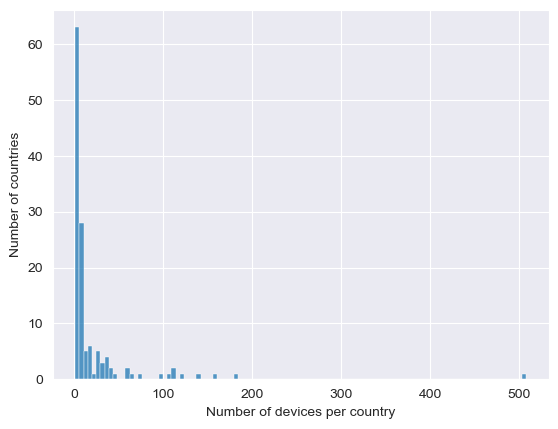

In [59]:
sns.histplot(devices['code'].value_counts())
plt.xlabel('Number of devices per country')
plt.ylabel('Number of countries')

The distribution is clearly disproportionate, due to very prominent outliers.

The data is highly skewed with high kurtosis.

In [60]:
print(f"Skewness: {stats.skew(devices['code'].value_counts())}\nKurtosis: {stats.kurtosis(devices['code'].value_counts())}")

Skewness: 6.366648462048307
Kurtosis: 51.15506691140475


<Axes: ylabel='count'>

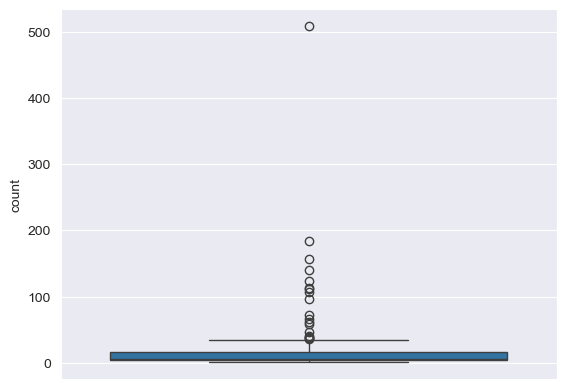

In [61]:
sns.boxplot(devices['code'].value_counts())

In [62]:
print(f"There are {count_outliers(devices['code'].value_counts())} outliers, which amount for {round(count_outliers(devices['code'].value_counts()) / devices['code'].value_counts().shape[0] * 100, 1)}% of unique values and {round(sum(devices['code'].value_counts().nlargest(19))/devices['code'].value_counts().sum()*100, 1)}% of all the rows.")

There are 19 outliers, which amount for 14.5% of unique values and 70.2% of all the rows.


One solution might be to group all the non-outliers into one category.

In [63]:
outlier_countries = devices['code'].value_counts().nlargest(19).index
updated_country_code = devices['code'].apply(lambda x: x if x in outlier_countries else 'Other')
updated_country_code.value_counts()

code
Other    862
US       508
IN       184
RU       156
DE       140
GB       123
BR       113
CN       111
FR       107
IT        96
JP        72
ES        66
PH        62
ID        59
PK        47
TH        40
UA        39
AU        37
NG        37
NL        36
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

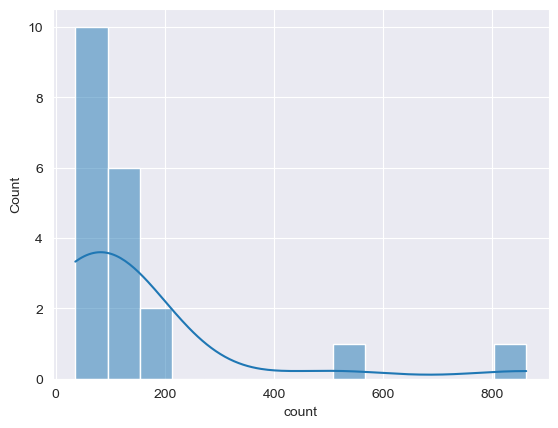

In [64]:
sns.histplot(updated_country_code.value_counts(), kde=True)

This has proven ineffective as well

Another option is grouping them by cumulative frequency.

In [65]:
country_counts = devices['code'].value_counts()
cumulative_freq=country_counts.cumsum() / country_counts.sum()
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Assign each country to a group (A, B, C, D, E) based on the cumulative frequency
group_labels = ['top20%', '20-40%', '40-60%', '60-80', 'bottom20%']
country_groups = pd.cut(cumulative_freq, bins=bins, labels=group_labels, include_lowest=True)
devices_copy = devices.copy()
devices_copy['country_device_share'] =devices['code'].map(country_groups)
devices_copy['country_device_share'].value_counts()

country_device_share
60-80        623
20-40%       603
bottom20%    596
40-60%       565
top20%       508
Name: count, dtype: int64

### Column: location

In [66]:
devices['location'].describe()

count                 2895
unique                 179
top       America/New_York
freq                   218
Name: location, dtype: object

In [67]:
devices['location'].value_counts().describe()

count    179.000000
mean      16.173184
std       31.931777
min        1.000000
25%        3.000000
50%        5.000000
75%       10.500000
max      218.000000
Name: count, dtype: float64

<Axes: xlabel='count', ylabel='Count'>

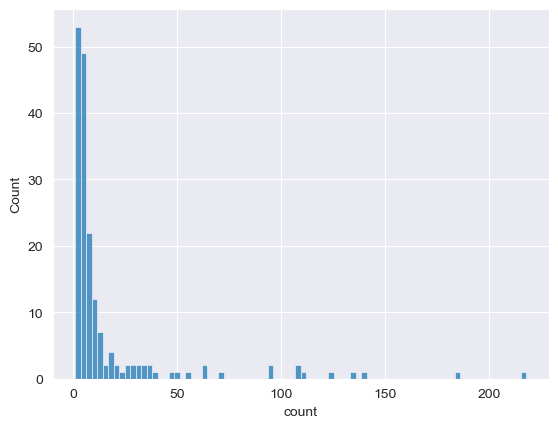

In [68]:
sns.histplot(devices['location'].value_counts())

In [69]:
print(f"Skewness: {stats.skew(devices['location'].value_counts())}\nKurtosis: {stats.kurtosis(devices['location'].value_counts())}")

Skewness: 3.7068891265244397
Kurtosis: 15.165283941188175


This column seems to have same problems as country code. Even if the distribution was better, the cardinality would be too high and highly correlated to store_name and other location-based columns, so we can just omit the city part of location. 

In [89]:
devices_copy['continent'] = devices['location'].map(lambda x: x.split('/')[0])
devices_copy['continent'].value_counts()

continent
Europe       930
America      851
Asia         780
Africa       262
Australia     37
Pacific       17
Indian        11
Atlantic       7
Name: count, dtype: int64

These are clearly better categories, as they are more evenly distributed and have less cardinality. Only Africa, Australia, Pacific, Indian and Atlantic should be merged into one category, as they are all very low in count.

<Axes: xlabel='continents', ylabel='count'>

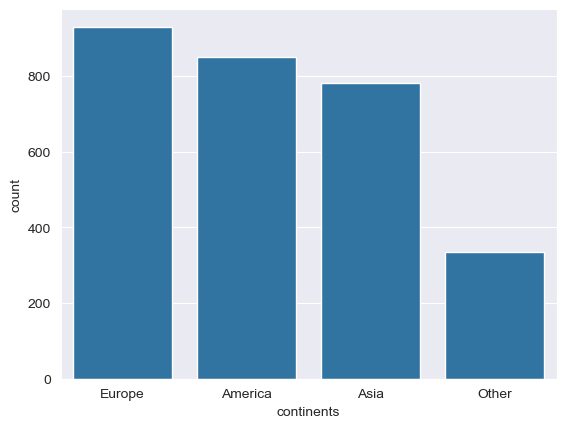

In [71]:
devices_copy['continent'] = devices_copy['continent'].map(lambda x: x if x not in ['Africa', 'Australia', 'Pacific', 'Indian', 'Atlantic'] else 'Other')
sns.barplot(devices_copy['continent'].value_counts())

Smaller cardinality, no huge outliers, more practical for machine learning.

### Column: processes - p.system

In [72]:
processes['p.system'].describe()

count    15074.000000
mean        10.055861
std          2.646287
min          0.051170
25%          8.189795
50%          9.794255
75%         11.811273
max         21.245590
Name: p.system, dtype: float64

Count is the same as row count, indicating no missing values. Mean is close to median, suggesting normal distribution. IQR is about 3.62 which is far from min and max suggesting outliers. Standard deviation is roughly 25% of the median suggesting moderate variability around the median.

<Axes: xlabel='p.system', ylabel='Count'>

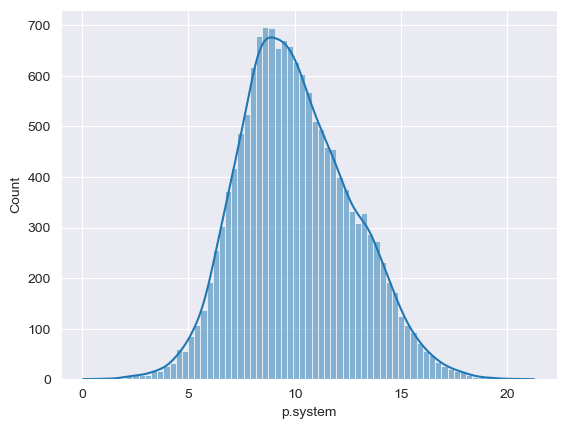

In [73]:
sns.histplot(processes['p.system'], kde=True)

Data appears to be normally distributed, not extraordinarily skewed nor having unusual kurtosis.

In [74]:
print(f"Skewness: {stats.skew(processes['p.system'])}\nKurtosis: {stats.kurtosis(processes['p.system'])}")

Skewness: 0.29895469791049273
Kurtosis: -0.04770725365747319


In [75]:
print(f"There are {count_outliers(processes['p.system'])} outliers in the column.")

There are 105 outliers in the column.


<Axes: ylabel='p.system'>

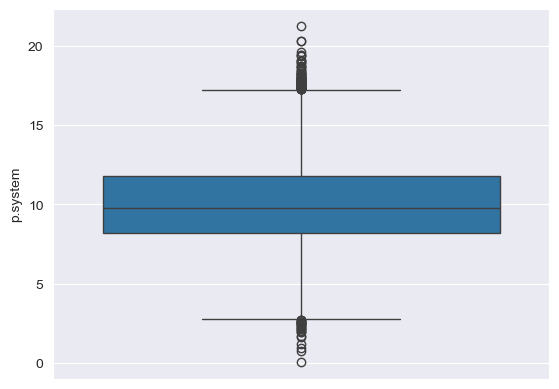

In [76]:
sns.boxplot(processes['p.system'])

### Column: processes - p.android.gm

In [77]:
processes['p.android.gm'].describe()

count    15074.000000
mean         9.428202
std          2.392442
min          1.529690
25%          7.834278
50%          9.165670
75%         10.747598
max         20.640630
Name: p.android.gm, dtype: float64

Count is the same as row count, indicating no missing values. Mean is close to median, suggesting normal distribution. IQR is about 2.91 which reveals few outliers for sure, as max and min aren't within 1.5 IQR of the 3rd and 1st quartile respectively.

<Axes: xlabel='p.android.gm', ylabel='Count'>

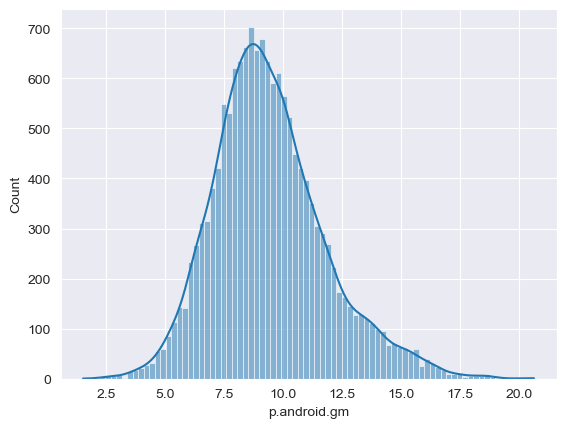

In [78]:
sns.histplot(processes['p.android.gm'], kde=True)

In [79]:
print(f"Skewness: {stats.skew(processes['p.android.gm'])}\nKurtosis: {stats.kurtosis(processes['p.android.gm'])}")

Skewness: 0.6239151528531606
Kurtosis: 0.7740757760005348


The column is in normal distribution. There is a right skew, but it's not too significant. The tails are slightly lighter as kurtosis suggests, but nothing significant either.

In [80]:
print(f"There are {count_outliers(processes['p.android.gm'])} outliers in the column, which amounts for {round(count_outliers(processes['p.android.gm'])/processes.shape[0]*100)}% of the entries.")

There are 405 outliers in the column, which amounts for 3% of the entries.


<Axes: ylabel='p.android.gm'>

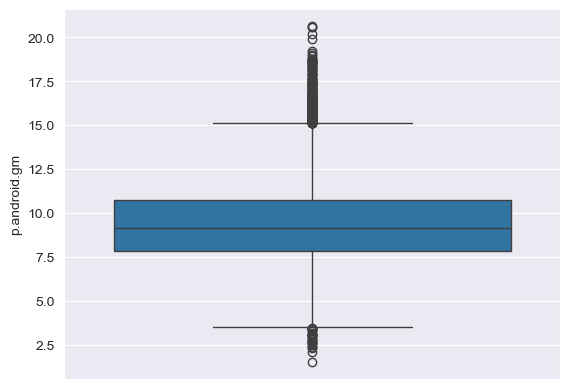

In [81]:
sns.boxplot(processes['p.android.gm'])

There is a higher percentage in outliers compared to other numerical columns previously observed, but that's good. Still nothing significant.

### Column: profiles - company

In [82]:
profiles['company'].describe()

count                 2605
unique                2464
top       Johnson and Sons
freq                     6
Name: company, dtype: object

The previous function shows 2464 out of 2605 companies are unique, meaning no real value for machine learning process later, as aren't doing LLMs, so we can't infer anything from the company.

In [83]:
profiles['company'].value_counts().describe()

count    2464.000000
mean        1.057224
std         0.295405
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         6.000000
Name: count, dtype: float64

Text(0, 0.5, 'Number of companies')

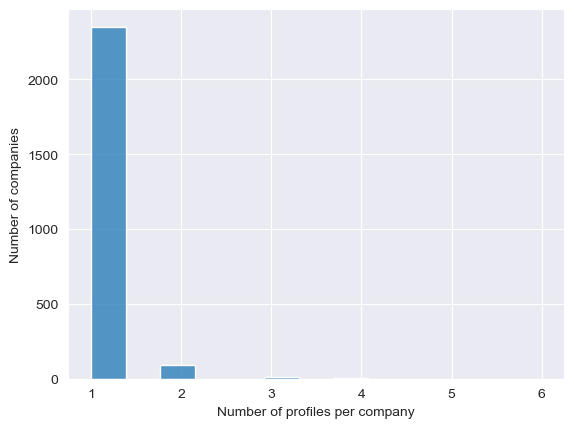

In [84]:
sns.histplot(profiles['company'].value_counts())
plt.xlabel('Number of profiles per company')
plt.ylabel('Number of companies')

As we can see, most of the companies have only one profile, which wouldn't be useful for machine learning.

## 1-1C

Columns likely to be correlated are all location columns in devices table. 

We can test it with chi square test. It calculates correlations between categorical values. The higher chi-squared statistic and the closer p-value is to 0, the more likely the columns are correlated.

In [85]:
contingency_table = pd.crosstab(devices['location'], devices['store_name'])
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Squared Statistic: {chi2_stat}\nP-Value: {p_val}")

Chi-Squared Statistic: 515309.99999999994
P-Value: 0.0


In [86]:
contingency_table = pd.crosstab(devices['store_name'], devices['code'])
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Squared Statistic: {chi2_stat}\nP-Value: {p_val}")

Chi-Squared Statistic: 376350.0
P-Value: 0.0


Test has shown that these values are clearly correlated.

Newly made columns continent and country_device_share are also likely to be correlated, as countries with more share are likely to be in the continents with most share. 

In [90]:
pd.crosstab(devices_copy['country_device_share'], devices_copy['continent'])

continent,Africa,America,Asia,Atlantic,Australia,Europe,Indian,Pacific
country_device_share,,,,,,,,
top20%,0,505,0,0,0,0,0,3
20-40%,0,0,239,0,0,364,0,0
40-60%,0,113,183,3,0,266,0,0
60-80,95,88,233,0,37,170,0,0
bottom20%,167,145,125,4,0,130,11,14


From the table, there seems to be a correlation. America is the only continent with a significant amount of countries in the top 20% share. Asia and Europe are mostly in the 20-80 categories and the other ones are mostly in the bottom 20%. Let's test the correlation also with chi-square test.

In [91]:
contingency_table = pd.crosstab(devices_copy['country_device_share'], devices_copy['continent'])
# Perform the Chi-Squared test
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Squared Statistic: {chi2_stat}\nP-Value: {p_val}")

Chi-Squared Statistic: 2329.9847986211107
P-Value: 0.0


Test has shown that these values are also clearly correlated.

# Phase 1-2


It looks like processes and connections have the same length and the same values in the columns ts, imei, mwra in respective rows. Let's check if this is true.

In [ ]:
(connections[['ts', 'imei', 'mwra']] == processes[['ts', 'imei', 'mwra']]).all().all() # .all().all() checks if all values across both dimensions are True

Previous cell has confirmed our suspicion, that these were the same snapshots. We can now join the tables

In [ ]:
actions = processes.join(connections.drop(columns=['ts', 'imei', 'mwra']), how='inner')

In [ ]:
actions['imei'].nunique(), processes['imei'].nunique(), connections['imei'].nunique()

In [ ]:
devices['imei'].nunique()

In [ ]:
# check what imei is in actions but not in devices
actions['imei'].isin(devices['imei']).all()
# get the false value
actions['imei'][~actions['imei'].isin(devices['imei'])]